In [ ]:
### This script generates a molecule using the trained VAE model and 
### predicts the property of the generated molecule using the trained GNN model

# Pretrained models 
from src.vae_module import VAE
from src.pretrainedmodel import GNNmodel

# Cheminformatics libraries
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
import numpy as np

### Required RL Libraries
import gymnasium as gym  # Import Gymnasium (successor of OpenAI Gym)
from stable_baselines3 import PPO  # Import the PPO algorithm from Stable Baselines3
from stable_baselines3.common.vec_env import DummyVecEnv  # Correct import for DummyVecEnv
import matplotlib.pyplot as plt
import logging
import sys
import torch

# import relevant functions
from utils import encode_data_from_smiles_to_vae_encoded
from utils import generate_vae_molecules
from utils import generate_molecules_from_latent


# Load the trained prediction model
graph_model_path = 'models'
prediction_model = GNNmodel(path = graph_model_path)

# load the trained VAE model
latent_dim = 32  # latent dimension of the VAE
vae = VAE(input_dim=3624, latent_dim=latent_dim)
vae.load_state_dict(torch.load('models/vae_model.pt'))

original_data = pd.read_csv('data/test_more_dataNoinionc.csv', header=None, names=['smiles', 'logCMC'])
original_data_input_smiles_list = original_data.iloc[:, 0].tolist()
# convert smiles to canonical smiles
original_data_input_smiles_list = [Chem.MolToSmiles(Chem.MolFromSmiles(sm), canonical=True) for sm in original_data_input_smiles_list]

# generate a molecule using the trained VAE model    
height, vocab_itos, width = encode_data_from_smiles_to_vae_encoded(original_data_input_smiles_list)
mol = generate_vae_molecules(1, height, vocab_itos, width, vae, latent_dim)
print(f'generated molecule: {mol[0]}')

# predict the property of the generated molecule using the trained GNN model
prop = prediction_model.predict(mol)
print(f'predicted property: {prop[0]}')

generated molecule: CCCCCCCCCCCCCCCC(O)COC(O)C(C)C(O)CO
predicted property: -2.220258593559265


In [ ]:
### RL Implementation and Training

# lists to store rewards
rewards = []
max_step = 100  # Maximum number of steps per episode
step_count_per_episode = []  # list to store the step count per episode

# Custom Gymnasium environment for Molecular Generation
class MoleculeEnv(gym.Env):
    def __init__(self, vae, prediction_model, latent_dim, height, vocab_itos, width, max_step=max_step):
        super(MoleculeEnv, self).__init__()

        # Initialize the VAE model and prediction model
        self.vae = vae
        self.prediction_model = prediction_model
        # Parameters related to the VAE and the latent space
        self.latent_dim = latent_dim
        self.height = height
        self.vocab_itos = vocab_itos
        self.width = width
        self.max_step = max_step  # Maximum number of steps per episode
        # Action space: continuous values between -5 and 5 to match the latent space
        self.action_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(latent_dim,), dtype=np.float32)
        # Observation space
        self.observation_space = gym.spaces.Box(low=-5.0, high=5.0, shape=(latent_dim,), dtype=np.float32)
        # Initialize the latent vector (state)
        self.state = torch.randn(1, self.latent_dim)

        # Initialized episode count
        self.episodes_count = 0

    def reset(self, seed=None):
        # Reset the environment
        self.state = torch.randn(1, self.latent_dim)
        self.current_step = 0  # Reset step counter
        self.episodes_count += 1 
        return self.state.numpy().flatten(), {}  # Return the state as a flattened NumPy array and an info dictionary

    def step(self, action):
        self.state =  self.state + 0.5*torch.tensor(action, dtype=torch.float32)
        # Clip the latent vector to the valid range [-5, 5]
        self.state = torch.clamp(self.state, -5.0, 5.0)
        self.current_step += 1  # Increment the step counter 
        # Decode the latent state using the VAE to generate a molecule
        generated_smiles_list = generate_molecules_from_latent(self.state, self.height, self.vocab_itos, self.width, self.vae)
        # Calculate the reward based on the predicted property value
        if generated_smiles_list:
            property_value = self.prediction_model.predict(generated_smiles_list)[0]
            reward = reward_function(property_value)  # Calculate the reward using the reward function
            done = property_value < -1.5 # End the episode if the desired property condition is met
            if done:
                self.desired_state = self.state.clone()  # Store the state if the condition is met 
                step_count_per_episode.append(self.current_step)  # Append the step count to the list               
        else:
            reward = -100  # Penalize if no valid molecule is generated
            done = False  # Episode continues if no valid molecule is generated  
        # End the episode if the maximum number of steps is reached
        if self.current_step >= self.max_step:
            done = True
       
        rewards.append(reward)  # Append the reward to the rewards list

        info = {"property_value": float(property_value)} if generated_smiles_list else {}  # Store the property value in the info dictionary
        return self.state.numpy().flatten(), reward, done, {}, info  # Return the new state, reward, done flag, and info
    
# Reward function to incentivize the agent to generate molecules with properties less than -1
def reward_function(property_value):
    if property_value <= -1.5:
        return   -10*(property_value + 1.5 ) # High reward for achieving the desired property
    else:
        return   -10*(property_value + 1.5)  # Penalize based on the distance from the desired threshold

# Configure logging
logging.basicConfig(filename="logs/training.txt", 
                    level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
try:
    # Redirect stdout to the logger file
    sys.stdout = open("logs/training.txt", "a")
    # Create and vectorize the custom Gym environment
    env = MoleculeEnv(vae, prediction_model, latent_dim, height, vocab_itos, width, max_step=max_step)
    env = DummyVecEnv([lambda: env])  # Vectorize the environment for parallelization
    # Initialize the PPO model
    model = PPO("MlpPolicy", env, verbose=1)
    # Log the start of training
    logger.info("Starting model training...")
    model.learn(total_timesteps=150000)
    # Log completion of training
    logger.info("Model training complete.")
    # Save the trained model
    model.save("RL_Agent")
    # Reset stdout to default
    sys.stdout.close()
    sys.stdout = sys.__stdout__

except Exception as e:
    # Log the exception details
    logger.error("An error occurred during training.", exc_info=True)
    # Reset stdout to default in case of error
    sys.stdout.close()
    sys.stdout = sys.__stdout__

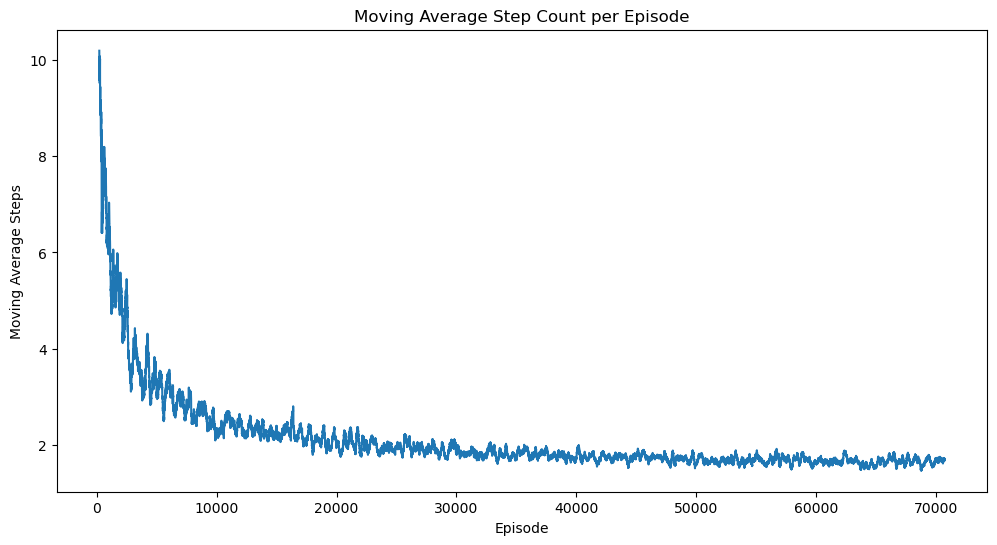

In [ ]:
episodes = len(step_count_per_episode)  # Get the number of episodes
# Plot of the moving average step count per episode vs episode
def moving_average(data, window_size):
    return [sum(data[i:i+window_size])/window_size for i in range(len(data)-window_size+1)]
window_size = 200
plt.figure(figsize=(12, 6))
plt.plot(range(window_size, episodes + 1), moving_average(step_count_per_episode, window_size))
plt.xlabel("Episode")
plt.ylabel("Moving Average Steps")
plt.title("Moving Average Step Count per Episode")
plt.savefig("moving_average_step_count.png",dpi=300)
plt.show()

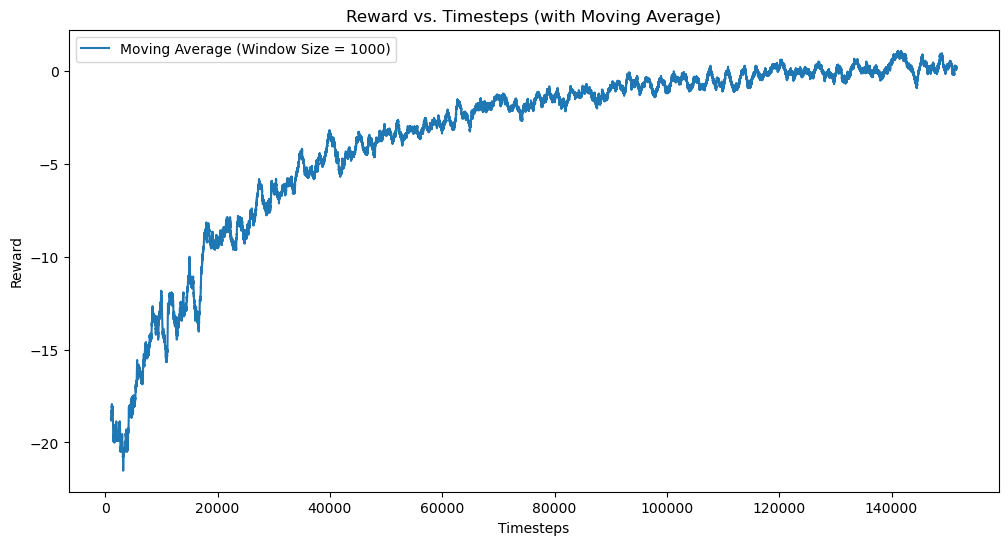

In [ ]:
window_size = 1000 # Smoothing window size
def moving_average(data, window_size=window_size):
    """Calculate the moving average of the data with the specified window size."""
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')
smoothed_rewards = moving_average(rewards, window_size)

plt.figure(figsize=(12, 6))
# Plot the moving average of rewards
plt.plot(range(window_size - 1, len(rewards)), smoothed_rewards, label=f"Moving Average (Window Size = {window_size})")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.title("Reward vs. Timesteps (with Moving Average)")
plt.legend()
plt.savefig("reward_vs_timesteps.png", dpi=300)
plt.show()

In [4]:
# Function to generate molecules using the trained RL agent on inference mode with a single step
def RL_agent(n, steps=1):
    generated_smiles_list = []
    for _ in range(n):
        # Reset the environment
        state = env.reset()
        for step in range(steps):
            action, _states = model.predict(state, deterministic=True)            
            state, reward, done, info = env.step(action)         
            if done[0]:  # Check the `done` flag in a vectorized environment
                break
        desired_state = env.get_attr("desired_state")[0]  # Access the stored state with the desired property
        latent_vector = torch.tensor(desired_state).squeeze(0)  # Remove the batch dimension from the state
        generated_smile = generate_molecules_from_latent(latent_vector, env.envs[0].height, env.envs[0].vocab_itos, env.envs[0].width, env.envs[0].vae)
        generated_smiles_list += generated_smile
    return generated_smiles_list

In [9]:
generated_smile = RL_agent(100)
duplicate_smiles = []
unique_smiles = []
for sm in generated_smile:
    if sm not in unique_smiles:
        unique_smiles.append(sm)
    else:
        duplicate_smiles.append(sm)
len(generated_smile), len(unique_smiles), len(duplicate_smiles)

C:\Users\okafo\AppData\Local\Temp\ipykernel_24804\4172396172.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latent_vector = torch.tensor(desired_state).squeeze(0)  # Remove the batch dimension from the state


(100, 69, 31)

In [10]:
generated_smile

['CCCCCCCCCCCCCCCC(O)CC1CCOC1C',
 'CCCCCCCCCCCCCCCC(O)CC1CCOC1C',
 'CCCCCCCCCCCCCCCCOCOOCCOCC(C)CCC(C)OOOCCOCCOCOCCOOOCOCCC',
 'CCCCCCCC/C=CCOC(C)CC(O)C(O)COCCC[C@H1]CCOO',
 'OCCOCCOCCCCCCCCCOCF',
 'CCCCCCCCCCCCCCCCCCOCCC(=O)C(O)C(O)COCOCCOCOF',
 'CC(C)CCCC(C)CCCCC1COCOC(CC)[C@@H1](O)[C@H1]1[C@@H1]O',
 'CCCCCCCCC=CCCCCCCCCOCOC1OCCOC(OCOCO1)OCOO',
 'CCCCCCCCC=CCCCCCCCCOC[C@@H1]CC(C)C[C@H1]CCO[C@H1]O',
 'CCCCCCCCC1CCCC(O)C(OCO)C1',
 'CCCCCCCCCCCCCCCCCC(C)COCC(C)=C',
 'CCCCCCCCCCCCCCCCCC(C)COCC(C)=C',
 'CCCCCCCCCCCCCCCCOC(CCCCCOCCCC)COOC',
 'CCCCCCCCCCCCCCCCCCOOCCOCCOCCCCC1OCCO1',
 'CCCCCCCCCCCCCCCCCCOOCCOCCOCCCCC1OCCO1',
 'CCCCCCCCCCCCCC(C1COCC=O)C(O)OCO1',
 'CCCCCCCCCCCCCCCCCCCCCCC(C)CCOOC',
 'CCCCCCCCCCCCCCCOCCSCCCCCF',
 'CCCCCCCCCCCCCCCOCCSCCCCCF',
 'CCCCCCCCCCCCCCCOCCSCCCCCF',
 'CCCCCCCCCCCCCCCC(O)C=CONC(C)CC',
 'CCCCCCCCCCCCCCCC(O)[C@@H1]',
 'CCCCCCCCCCCCCCC=O',
 'CCCCCCCCCCCCCCC=O',
 'CCCCCCCCC=CCCCCCCCC(CCCC)CCC1CCCCOCO1',
 'CCCCCCCCC=CCCCCCCCC(CCCC)CCC1CCCCOCO1',
 'CCCCCCCCCCCCCC

In [11]:
# number of generated molecules within the desired property range
prop = prediction_model.predict(generated_smile)
len([p for p in prop if p < -1.5])

100

In [12]:
# property values of the generated molecules
prop

[-2.138781726360321,
 -2.138781726360321,
 -1.5220977067947388,
 -1.793316662311554,
 -3.260291576385498,
 -1.8170884847640991,
 -1.6603316068649292,
 -1.9568475484848022,
 -1.753964364528656,
 -2.1425746083259583,
 -3.0577019453048706,
 -3.0577019453048706,
 -1.5907354950904846,
 -3.275150418281555,
 -3.275150418281555,
 -2.070232093334198,
 -4.219732046127319,
 -2.980256676673889,
 -2.980256676673889,
 -2.980256676673889,
 -2.065666973590851,
 -2.4696966409683228,
 -2.526543140411377,
 -2.526543140411377,
 -2.3496458530426025,
 -2.3496458530426025,
 -2.0610164999961853,
 -2.0610164999961853,
 -1.642473578453064,
 -1.642473578453064,
 -2.4347251653671265,
 -2.4347251653671265,
 -2.4347251653671265,
 -2.4408360719680786,
 -1.8334813714027405,
 -1.6722177863121033,
 -2.076883375644684,
 -2.076883375644684,
 -1.7954266667366028,
 -2.092395067214966,
 -1.521586835384369,
 -3.186757802963257,
 -1.6336395740509033,
 -3.319054126739502,
 -1.9601907134056091,
 -2.2494590282440186,
 -2.8871680

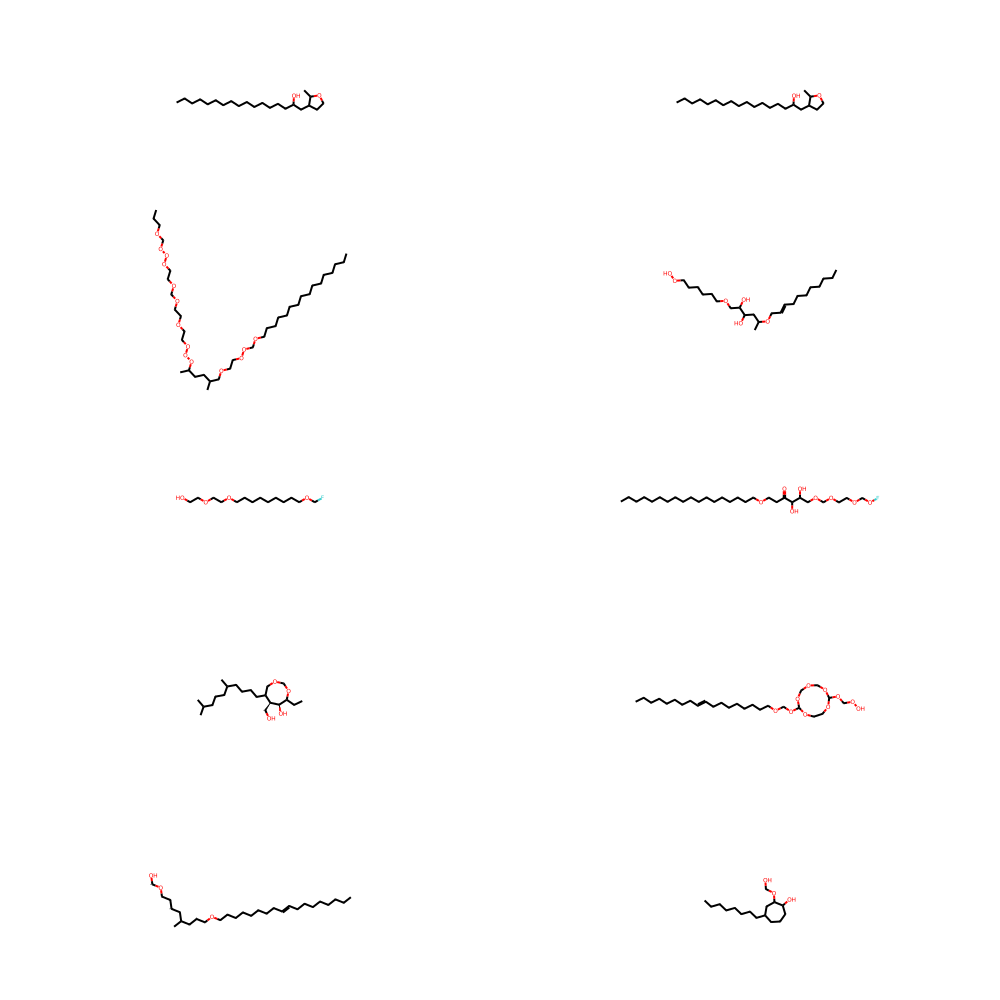

In [ ]:
mols = [Chem.MolFromSmiles(sm) for sm in generated_smile]
Draw.MolsToGridImage(mols[:10], molsPerRow=2, subImgSize=(500, 200))

In [13]:
# randomly generating moelcules without agent intervention
mol = generate_vae_molecules(100, height, vocab_itos, width, vae, latent_dim)
prop = prediction_model.predict(mol)
# how many properties are less than -1.5
len([p for p in prop if p < -1])

46